# Using SBI to infer parameter given observed data

Once simulated data has been generated (see `1_simulation` notebook), applying SBI is straight forward using the `sbi` package: 

- select an SBI method, we use SNPE (see paper for details)
- add the simulated data and corresponding parameters to the SNPE object
- call `train()` to start the training of the underlying neural networks
- obtain the posterior, DONE. 

In [1]:
import pickle

from sbi.analysis import pairplot
from sbi.inference import SNPE
from sbi.utils import posterior_nn

from consbi import DATA_PATH, RESULTS_PATH, BASE_PATH

In [2]:
# Load data
with open(DATA_PATH.joinpath("presimulated_dso_gaussian005_n1000000.p"), "rb") as fh:
    prior, theta, x = pickle.load(fh).values()

In [5]:
# Set up inference
trainer = SNPE(
    prior,
    # we pass NSF to specify to type of neural network used to learn the posterior approximation. 
    # NSF = neural spline flow (Durkan et al. 2019).
    density_estimator="nsf",
)

# add training data to trainer.
num_training_data = 100000
trainer.append_simulations(theta[:num_training_data], x[:num_training_data]);

In [6]:
# train
posterior_estimator = trainer.train(training_batch_size=100)

 Neural network successfully converged after 73 epochs.

In [7]:
# obtain posterior
posterior = trainer.build_posterior()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

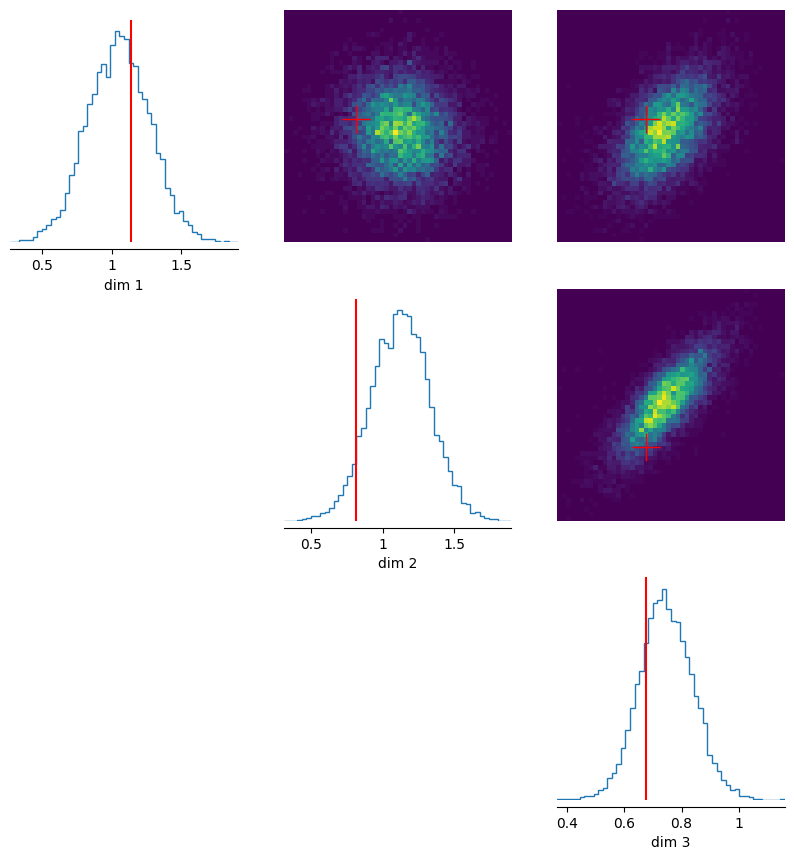

In [12]:
# we trained on simulated data. 
# To perform inference we would normally pass the actually observed data to the posterior object.
# Here, for demonstration we simpy pass the first object in the training data set as observed data.
# In practice, one would insert the actual measurements here. 
x_o = x[:1]

# Because we simulated our "measurements", we actually know the underlying ground truth parameters used to generate this data.
# In the plot below we will see how the posterior nicely clusters around this parameter value.
theta_o = theta[:1]

# pass x_o and generate samples
samples = posterior.sample((10000,), x=x_o)
# plot as pairplot.
pairplot(samples, points=theta_o, points_colors=["r"], points_offdiag=dict(marker="+"));

Lastly, we save the inference object for analysis. See `3_posterior_analysis` for more.

In [13]:
# save posterior for analysis
with open(RESULTS_PATH.joinpath(f"tutorial_posterior_gaussian005_N{num_training_data}.p"), "wb") as fh: 
    pickle.dump(dict(prior=prior, 
                     posterior=posterior, 
                     theta=theta,
                     x=x, 
                    ),
                fh,
               )